## dataset

In [ ]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [ ]:
!mkdir cartoons
!mkdir cartoons/1
!unzip -n -q /content/data/My\ Drive/cartoonGAN/safebooru.zip -d cartoons/1/ #extract to subfolder due to DataLoader needs subdirectories

unzip:  cannot find or open /content/data/My Drive/cartoonGAN/safebooru.zip, /content/data/My Drive/cartoonGAN/safebooru.zip.zip or /content/data/My Drive/cartoonGAN/safebooru.zip.ZIP.


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split
import math

image_size = 256
batch_size = 16

transformer = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor() # ToTensor() changes the range of the values from [0, 255] to [0.0, 1.0]
])

cartoon_dataset = ImageFolder('cartoons/', transformer)
len_training_set = math.floor(len(cartoon_dataset) * 0.9)
len_valid_set = len(cartoon_dataset) - len_training_set

training_set, _ = random_split(cartoon_dataset, (len_training_set, len_valid_set))
cartoon_image_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)

FileNotFoundError: Found no valid file for the classes 1. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

#### show examples

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_image(dataloader):
    iterator = iter(dataloader)
    sample_batch, _ = next(iterator)  # Use the built-in `next` function
    first_sample_image_of_batch = sample_batch[0]
    print(first_sample_image_of_batch.size())
    print("Current range: {} to {}".format(first_sample_image_of_batch.min(), first_sample_image_of_batch.max()))
    plt.imshow(np.transpose(first_sample_image_of_batch.numpy(), (1, 2, 0)))

# Assuming `cartoon_image_dataloader_train` is correctly defined
show_sample_image(cartoon_image_dataloader_train)


NameError: name 'cartoon_image_dataloader_train' is not defined

In [ ]:
!mkdir cartoons_smoothed
!mkdir cartoons_smoothed/1
!unzip -n -q /content/data/My\ Drive/cartoonGAN/safebooru_smoothed.zip -d cartoons_smoothed/1/ #extract to subfolder due to DataLoader needs subdirectories

unzip:  cannot find or open /content/data/My Drive/cartoonGAN/safebooru_smoothed.zip, /content/data/My Drive/cartoonGAN/safebooru_smoothed.zip.zip or /content/data/My Drive/cartoonGAN/safebooru_smoothed.zip.ZIP.


In [ ]:
smoothed_cartoon_dataset = ImageFolder('cartoons_smoothed/', transformer)
len_training_set = math.floor(len(smoothed_cartoon_dataset) * 0.9)
len_valid_set = len(smoothed_cartoon_dataset) - len_training_set
training_set, _ = random_split(smoothed_cartoon_dataset, (len_training_set, len_valid_set))
smoothed_cartoon_image_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)

FileNotFoundError: Found no valid file for the classes 1. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

#### show examples

In [ ]:


show_sample_image(smoothed_cartoon_image_dataloader_train)

NameError: name 'smoothed_cartoon_image_dataloader_train' is not defined

### photos

- photos are located in file `content/data/My Drive/cartoonGAN/coco.zip` of this notebook
- extract images and place in folder `photos` by executing cell below

In [ ]:
!mkdir photos
!mkdir photos/1
!unzip -n -q /content/data/My\ Drive/cartoonGAN/coco.zip -d photos/1 #extract to subfolder due to DataLoader needs subdirectories

unzip:  cannot find or open /content/data/My Drive/cartoonGAN/coco.zip, /content/data/My Drive/cartoonGAN/coco.zip.zip or /content/data/My Drive/cartoonGAN/coco.zip.ZIP.


In [ ]:
photo_dataset = ImageFolder('photos/', transformer)
len_training_set = math.floor(len(photo_dataset) * 0.9)
len_valid_set = len(photo_dataset) - len_training_set
training_set, validation_set = random_split(photo_dataset, (len_training_set, len_valid_set))
photo_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)
photo_dataloader_valid = DataLoader(validation_set, batch_size, shuffle=True, num_workers=0)

FileNotFoundError: Found no valid file for the classes 1. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

#### show examples

In [ ]:
show_sample_image(photo_dataloader_train)

NameError: name 'photo_dataloader_train' is not defined

In [ ]:
!mkdir /content/data/My\ Drive/cartoonGAN/tensorboard/

In [ ]:


%tensorflow_version 2.x

from torch.utils.tensorboard import SummaryWriter

tensorboard_logdir = '/content/data/My Drive/cartoonGAN/tensorboard'
writer = SummaryWriter(tensorboard_logdir)

###Generator

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch import sigmoid

class ResidualBlock(nn.Module):
  def __init__(self):
    super(ResidualBlock, self).__init__()
    self.conv_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.norm_1 = nn.BatchNorm2d(256)
    self.norm_2 = nn.BatchNorm2d(256)

  def forward(self, x):
    output = self.norm_2(self.conv_2(F.relu(self.norm_1(self.conv_1(x)))))
    return output + x #ES

class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)
      self.norm_1 = nn.BatchNorm2d(64)

      # down-convolution #
      self.conv_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
      self.conv_3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.norm_2 = nn.BatchNorm2d(128)

      self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
      self.conv_5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
      self.norm_3 = nn.BatchNorm2d(256)

      # residual blocks #
      residualBlocks = []
      for l in range(8):
        residualBlocks.append(ResidualBlock())
      self.res = nn.Sequential(*residualBlocks)

      # up-convolution #
      self.conv_6 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
      self.conv_7 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.norm_4 = nn.BatchNorm2d(128)

      self.conv_8 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
      self.conv_9 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
      self.norm_5 = nn.BatchNorm2d(64)

      self.conv_10 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
      x = F.relu(self.norm_1(self.conv_1(x)))

      x = F.relu(self.norm_2(self.conv_3(self.conv_2(x))))
      x = F.relu(self.norm_3(self.conv_5(self.conv_4(x))))

      x = self.res(x)
      x = F.relu(self.norm_4(self.conv_7(self.conv_6(x))))
      x = F.relu(self.norm_5(self.conv_9(self.conv_8(x))))

      x = self.conv_10(x)

      x = sigmoid(x)

      return x

In [ ]:
G = Generator()
print(G)

Generator(
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res): Sequential(
    (0): ResidualBlock(
      (conv_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

### Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
     super(Discriminator, self).__init__()
     self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

     self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
     self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
     self.norm_1 = nn.BatchNorm2d(128)

     self.conv_4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)
     self.conv_5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
     self.norm_2 = nn.BatchNorm2d(256)

     self.conv_6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
     self.norm_3 = nn.BatchNorm2d(256)

     self.conv_7 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    x = F.leaky_relu(self.conv_1(x))
    x = F.leaky_relu(self.norm_1(self.conv_3(F.leaky_relu(self.conv_2(x)))), negative_slope=0.2)
    x = F.leaky_relu(self.norm_2(self.conv_5(F.leaky_relu(self.conv_4(x)))), negative_slope=0.2)
    x = F.leaky_relu(self.norm_3(self.conv_6(x)), negative_slope=0.2)
    x = self.conv_7(x)
    x = sigmoid(x)

    return x

In [ ]:
D = Discriminator()
print(D)

Discriminator(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_7): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### use device CPU or GPU

In [ ]:
import torch

device = torch.device('cpu')

if torch.cuda.is_available():
  device = torch.device('cuda')
  print("Train on GPU.")
else:
  print("No cuda available")

G.to(device)
D.to(device)

Train on GPU.


Discriminator(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_7): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
from torchvision import models
import torch

path_to_pretrained_vgg16 = '/content/data/My Drive/cartoonGAN/vgg16-397923af.pth'

try:
    # Load the state dictionary if the file exists
    pretrained = torch.load(path_to_pretrained_vgg16)
    if isinstance(pretrained, dict):  # Check if the file contains a state dict
        vgg16 = models.vgg16(pretrained=False)
        vgg16.load_state_dict(pretrained)
    else:  # If it's a full model, extract its state dict
        vgg16 = pretrained
    vgg16 = vgg16.to(device)
except FileNotFoundError:
    # Download the pretrained VGG16 model and save its state dict
    vgg16 = models.vgg16(pretrained=True)
    torch.save(vgg16.state_dict(), path_to_pretrained_vgg16)  # Save only the state dict
    vgg16 = vgg16.to(device)

print(vgg16)

# Use the feature extractor up to the 4th pooling layer
feature_extractor = vgg16.features[:24]
for param in feature_extractor.parameters():
    param.requires_grad = False

print(feature_extractor)


<ipython-input-22-5a59db40ac90>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained = torch.load(path_to_pretrained_vgg16)


RuntimeError: Parent directory /content/data/My Drive/cartoonGAN does not exist.

### Two loss functions

- discriminator loss
- generator initialization phase loss and generator loss

In [ ]:
from torchvision import models
from torch.nn import BCELoss

class DiscriminatorLoss(torch.nn.Module):
  def __init__(self):
      super(DiscriminatorLoss, self).__init__()
      self.bce_loss = BCELoss()

  def forward(self, discriminator_output_of_cartoon_input,
              discriminator_output_of_cartoon_smoothed_input,
              discriminator_output_of_generated_image_input,
              epoch,
              write_to_tensorboard=False):

    return self._adversarial_loss(discriminator_output_of_cartoon_input,
                     discriminator_output_of_cartoon_smoothed_input,
                     discriminator_output_of_generated_image_input,
                     epoch,
                     write_to_tensorboard)

  def _adversarial_loss(self, discriminator_output_of_cartoon_input,
                     discriminator_output_of_cartoon_smoothed_input,
                     discriminator_output_of_generated_image_input,
                     epoch,
                     write_to_tensorboard):

    # define ones and zeros here instead within __init__ due to have same shape as input
    # due to testing different batch_sizes, sometimes the "last batch" has < batch_size elements
    actual_batch_size = discriminator_output_of_cartoon_input.size()[0]
    zeros = torch.zeros([actual_batch_size, 1, 64, 64]).to(device)
    ones = torch.ones([actual_batch_size, 1, 64, 64]).to(device)

    d_loss_cartoon = self.bce_loss(discriminator_output_of_cartoon_input, ones)
    d_loss_cartoon_smoothed = self.bce_loss(discriminator_output_of_cartoon_smoothed_input, zeros)
    d_loss_generated_input = self.bce_loss(discriminator_output_of_generated_image_input, zeros)

    d_loss = d_loss_cartoon + d_loss_cartoon_smoothed + d_loss_generated_input

    if write_to_tensorboard:
      writer.add_scalar('d_loss_cartoon', d_loss_cartoon,epoch)
      writer.add_scalar('d_loss_cartoon_smoothed', d_loss_cartoon_smoothed, epoch)
      writer.add_scalar('d_loss_generated_input', d_loss_generated_input, epoch)
      writer.add_scalar('d_loss', d_loss, epoch)

    return d_loss

In [ ]:
class GeneratorLoss(torch.nn.Module):
  def __init__(self):
      super(GeneratorLoss, self).__init__()
      self.w = 0.000005
      self.bce_loss = BCELoss()
      self.feature_extractor = vgg16.features[:24]
      for param in self.feature_extractor.parameters():
        param.require_grad = False

  def forward(self, discriminator_output_of_generated_image_input,
              generator_input,
              generator_output,
              epoch,
              is_init_phase=False,
              write_to_tensorboard=False):
    if is_init_phase:
      g_content_loss = self._content_loss(generator_input, generator_output)
      g_adversarial_loss = 0.0
      g_loss = g_content_loss
    else:
      g_adversarial_loss = self._adversarial_loss_generator_part_only(discriminator_output_of_generated_image_input)
      g_content_loss = self._content_loss(generator_input, generator_output)
      g_loss = g_adversarial_loss + self.w * g_content_loss

    if write_to_tensorboard:
      writer.add_scalar('g_adversarial_loss', g_adversarial_loss, epoch)
      writer.add_scalar('g_content_loss', g_content_loss, epoch)
      writer.add_scalar('g_loss', g_loss, epoch)

    return g_loss

  def _adversarial_loss_generator_part_only(self, discriminator_output_of_generated_image_input):
    actual_batch_size = discriminator_output_of_generated_image_input.size()[0]
    ones = torch.ones([actual_batch_size, 1, 64, 64]).to(device)
    return self.bce_loss(discriminator_output_of_generated_image_input, ones)

  def _content_loss(self, generator_input, generator_output):
    return (self.feature_extractor(generator_output) - self.feature_extractor(generator_input)).norm(p=1)

In [ ]:
discriminatorLoss = DiscriminatorLoss()
generatorLoss = GeneratorLoss()

## Optimizer

In [ ]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [ ]:
!mkdir /content/data/My\ Drive/cartoonGAN/checkpoints/
!mkdir -p /content/data/My\ Drive/cartoonGAN/intermediate_results/training/
intermediate_results_training_path = "/content/data/My Drive/cartoonGAN/intermediate_results/training/"

mkdir: cannot create directory ‘/content/data/My Drive/cartoonGAN/checkpoints/’: No such file or directory


In [ ]:
def save_training_result(input, output):
  # input/output has batch-size number of images, get first one and detach from tensor
  image_input = input[0].detach().cpu().numpy()
  image_output = output[0].detach().cpu().numpy()
  # transponse image from torch.Size([3, 256, 256]) to (256, 256, 3)
  image_input = np.transpose(image_input, (1, 2, 0))
  image_output = np.transpose(image_output, (1, 2, 0))

  # generate filenames as timestamp, this orders the output by time
  filename = str(int(time.time()))
  path_input = intermediate_results_training_path + filename + "_input.jpg"
  path_output = intermediate_results_training_path + filename + ".jpg"
  plt.imsave(path_input, image_input)
  plt.imsave(path_output, image_output)

In [ ]:
def write_model_weights_and_bias_to_tensorboard(prefix, state_dict, epoch):
  for param in state_dict:
      writer.add_histogram(f"{prefix}_{param}", state_dict[param], epoch)

## Training

In [ ]:
import time

def train(_num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses):
  init_epochs = 10
  print_every = 100
  start_time = time.time()

  for epoch in range(_num_epochs - epochs_already_done):
    epoch = epoch + epochs_already_done

    for index, ((photo_images, _), (smoothed_cartoon_images, _), (cartoon_images, _)) in enumerate(zip(photo_dataloader_train, smoothed_cartoon_image_dataloader_train, cartoon_image_dataloader_train)):
      batch_size = photo_images.size(0)
      photo_images = photo_images.to(device)
      smoothed_cartoon_images = smoothed_cartoon_images.to(device)
      cartoon_images = cartoon_images.to(device)

      # train the discriminator
      d_optimizer.zero_grad()

      d_of_cartoon_input = D(cartoon_images)
      d_of_cartoon_smoothed_input = D(smoothed_cartoon_images)
      d_of_generated_image_input = D(G(photo_images))

      write_only_one_loss_from_epoch_not_every_batch_loss = (index == 0)

      d_loss = discriminatorLoss(d_of_cartoon_input,
                                 d_of_cartoon_smoothed_input,
                                 d_of_generated_image_input,
                                 epoch,
                                 write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

      d_loss.backward()
      d_optimizer.step()

      # train the generator
      g_optimizer.zero_grad()

      g_output = G(photo_images)

      d_of_generated_image_input = D(g_output)

      if epoch < init_epochs:
        # init
        init_phase = True
      else:
        # train
        init_phase = False

      g_loss = generatorLoss(d_of_generated_image_input,
                              photo_images,
                              g_output,
                              epoch,
                              is_init_phase=init_phase,
                              write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

      g_loss.backward()
      g_optimizer.step()

      if (index % print_every) == 0:
        losses.append((d_loss.item(), g_loss.item()))
        now = time.time()
        current_run_time = now - start_time
        start_time = now
        print("Epoch {}/{} | d_loss {:6.4f} | g_loss {:6.4f} | time {:2.0f}s | total no. of losses {}".format(epoch+1, _num_epochs, d_loss.item(), g_loss.item(), current_run_time, len(losses)))

    # write to tensorboard
      #write_model_weights_and_bias_to_tensorboard('D', D.state_dict(), epoch)
      #write_model_weights_and_bias_to_tensorboard('G', G.state_dict(), epoch)
    # save some intermediate results during training
    save_training_result(photo_images, g_output)

    # validate
    with torch.no_grad():
      D.eval()
      G.eval()

      for batch_index, (photo_images, _) in enumerate(photo_dataloader_valid):
        photo_images = photo_images.to(device)

        g_output = G(photo_images)
        d_of_generated_image_input = D(g_output)
        g_valid_loss = generatorLoss(d_of_generated_image_input,
                                      photo_images,
                                      g_output,
                                      epoch,
                                      is_init_phase=init_phase,
                                      write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

        if batch_index % print_every == 0:
          validation_losses.append(g_valid_loss.item())
          now = time.time()
          current_run_time = now - start_time
          start_time = now
          print("Epoch {}/{} | validation loss {:6.4f} | time {:2.0f}s | total no. of losses {}".format(epoch+1, _num_epochs, g_valid_loss.item(), current_run_time, len(validation_losses)))

    D.train()
    G.train()

    if(g_valid_loss.item() < best_valid_loss):
      print("Generator loss improved from {} to {}".format(best_valid_loss, g_valid_loss.item()))
      best_valid_loss = g_valid_loss.item()

    # save checkpoint
    checkpoint = {'g_valid_loss': g_valid_loss.item(),
                  'best_valid_loss': best_valid_loss,
                  'losses': losses,
                  'validation_losses': validation_losses,
                  'last_epoch': epoch+1,
                  'd_state_dict': D.state_dict(),
                  'g_state_dict': G.state_dict(),
                  'd_optimizer_state_dict': d_optimizer.state_dict(),
                  'g_optimizer_state_dict': g_optimizer.state_dict()
                }
    print("Save checkpoint for validation loss of {}".format(g_valid_loss.item()))
    torch.save(checkpoint, checkpoint_dir + '/checkpoint_epoch_{:03d}.pth'.format(epoch+1))
    if(best_valid_loss == g_valid_loss.item()):
      print("Overwrite best checkpoint")
      torch.save(checkpoint, checkpoint_dir + '/best_checkpoint.pth')

  return losses, validation_losses

In [ ]:
from os import listdir
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

checkpoint_dir = '/content/data/My Drive/cartoonGAN/checkpoints'
checkpoints = listdir(checkpoint_dir)
num_epochs = 200 + 10 # training + init phase
epochs_already_done = 0
best_valid_loss = math.inf
losses = []
validation_losses = []

if(len(checkpoints) > 0):
  last_checkpoint = sorted(checkpoints)[-1]
  checkpoint = torch.load(checkpoint_dir + '/' + last_checkpoint, map_location=torch.device(device))
  best_valid_loss = checkpoint['best_valid_loss']
  epochs_already_done = checkpoint['last_epoch']
  losses = checkpoint['losses']
  validation_losses = checkpoint['validation_losses']

  D.load_state_dict(checkpoint['d_state_dict'])
  G.load_state_dict(checkpoint['g_state_dict'])
  d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
  g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
  print('Load checkpoint {} with g_valid_loss {}, best_valid_loss {}, {} epochs and total no of losses {}'.format(last_checkpoint, checkpoint['g_valid_loss'], best_valid_loss, epochs_already_done, len(losses)))


<ipython-input-27-640de6358ed8>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_dir + '/' + last_checkpoint, map_location=torch.device(d

Load checkpoint checkpoint_epoch_091.pth with g_valid_loss 5.197726726531982, best_valid_loss 2.803353786468506, 91 epochs and total no of losses 273


In [ ]:
losses, validation_losses = train(num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses)

Epoch 92/210 | d_loss 0.9546 | g_loss 5.4341 | time  4s | total no. of losses 274
Epoch 92/210 | d_loss 2.5401 | g_loss 4.8401 | time 277s | total no. of losses 275
Epoch 92/210 | d_loss 0.9773 | g_loss 4.5595 | time 284s | total no. of losses 276
Epoch 92/210 | validation loss 5.9446 | time 69s | total no. of losses 92
Save checkpoint for validation loss of 5.528900623321533
Epoch 93/210 | d_loss 0.7941 | g_loss 6.2796 | time 16s | total no. of losses 277
Epoch 93/210 | d_loss 0.6210 | g_loss 5.1764 | time 282s | total no. of losses 278
Epoch 93/210 | d_loss 1.0545 | g_loss 5.9098 | time 282s | total no. of losses 279
Epoch 93/210 | validation loss 5.2602 | time 68s | total no. of losses 93
Save checkpoint for validation loss of 5.530035018920898
Epoch 94/210 | d_loss 1.4438 | g_loss 5.9506 | time 15s | total no. of losses 280
Epoch 94/210 | d_loss 0.7069 | g_loss 6.9657 | time 281s | total no. of losses 281
Epoch 94/210 | d_loss 1.3578 | g_loss 4.8450 | time 281s | total no. of losse

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = [image_folder + "/" + f for f in os.listdir(image_folder) if f.endswith(".png")]  # adjust this for your image types

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = read_image(image_path)
        if self.transform:
            image = self.transform(image)
        return image, 0  # You can return the label if needed

# Define transformations if needed (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to your desired image size
    transforms.ToTensor(),
])

# Define the path to your images
image_folder = "/content/data/MyDrive/cartoonGAN/intermediate_results/training"

# Create the dataset and dataloader
dataset = CustomDataset(image_folder, transform)
test_dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# Now you can use test_dataloader in your view_results function
view_results(G, D, test_dataloader, device)


NameError: name 'os' is not defined

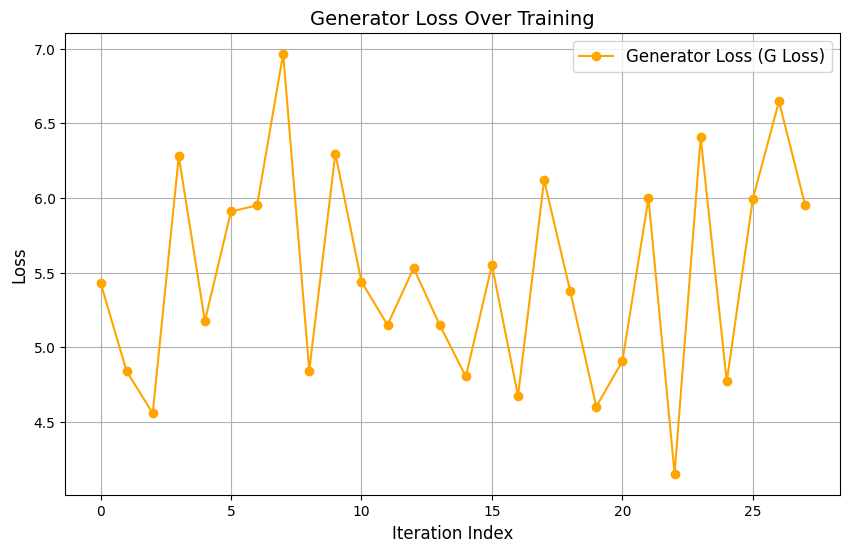

In [ ]:
import matplotlib.pyplot as plt

# Generator loss values
g_loss = [
    5.4341, 4.8401, 4.5595, 6.2796, 5.1764, 5.9098,
    5.9506, 6.9657, 4.8450, 6.2974, 5.4393, 5.1501,
    5.5306, 5.1498, 4.8051, 5.5517, 4.6760, 6.1200,
    5.3769, 4.6036, 4.9079, 5.9980, 4.1543, 6.4060,
    4.7723, 5.9948, 6.6465, 5.9548
]

# Generate an index for each `g_loss` entry
loss_indices = list(range(len(g_loss)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(loss_indices, g_loss, marker='o', color='orange', label="Generator Loss (G Loss)")
plt.title("Generator Loss Over Training", fontsize=14)
plt.xlabel("Iteration Index", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()
